In [1]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

In [2]:
df = pd.read_csv('data/california/housing.csv')
df = df.dropna()

# Q1 - IQR * 1.5 < N < Q3 + IQR * 1.5
for column in ['total_rooms', 'total_bedrooms', 'population', 'households']:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    lim_low = q1 - iqr * 1.5
    lim_high = q3 + iqr * 1.5
    df = df[(lim_low < df[column]) & (df[column] < lim_high)]

<Axes: xlabel='latitude', ylabel='longitude'>

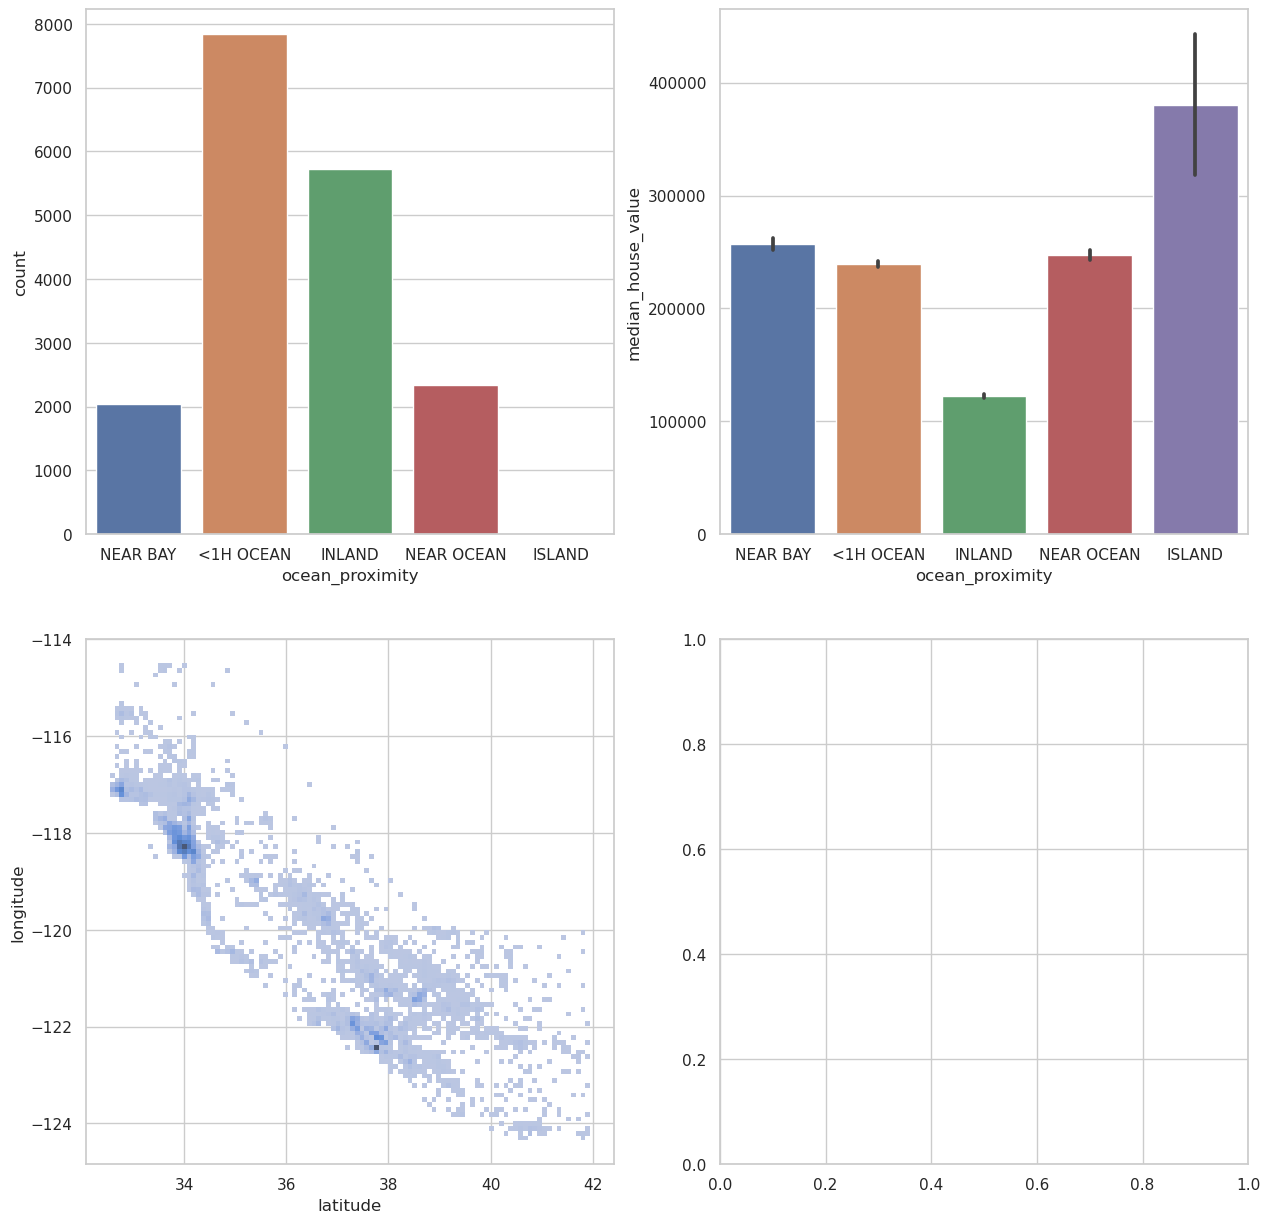

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

sns.countplot(data=df, x='ocean_proximity', ax=axes[0, 0])
sns.barplot(x=df['ocean_proximity'], y=df['median_house_value'], ax=axes[0, 1])
sns.histplot(x=df['latitude'], y=df['longitude'], bins=100, ax=axes[1, 0])

In [4]:
# sns.pairplot(df.sample(1000), kind='hist', corner=True)

<Axes: >

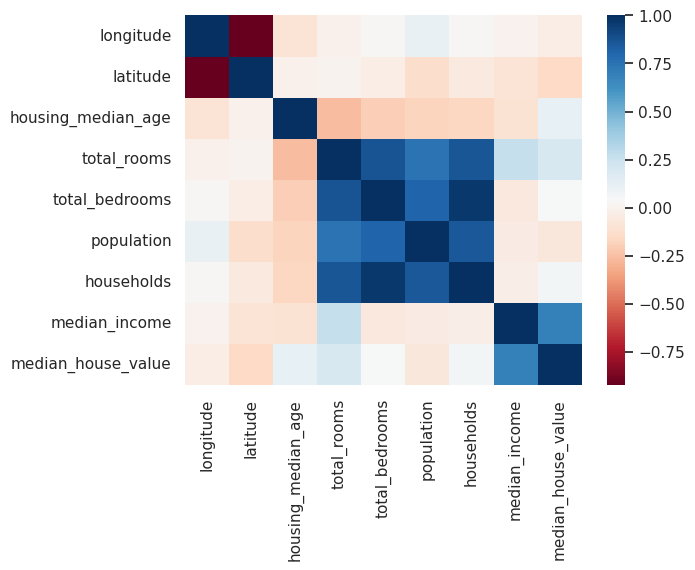

In [5]:
sns.heatmap(df.corr(numeric_only=True), cmap='RdBu')

In [6]:
df = pd.concat([df, pd.get_dummies(df['ocean_proximity'], drop_first=True)], axis=1)
df = df.drop('ocean_proximity', axis=1)

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(['median_house_value'], axis=1)
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [8]:
model = lgb.LGBMRegressor(
    random_state=0,
    n_estimators=300,
    max_depth=50,
    boosting_type='goss',
    learning_rate=0.1
)

In [12]:
callbacks = [lgb.early_stopping(stopping_rounds=10)]
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, callbacks=callbacks, eval_set=eval_set)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[230]	valid_0's l2: 2.30681e+09


LGBMRegressor(boosting_type='goss', max_depth=50, n_estimators=300,
              random_state=0)

In [13]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model.predict(X_train)
r2 = r2_score(y_train, y_pred)
rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f'FITTING --- r2: { r2 }, rmse: { rmse }')

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'TESTING --- r2: { r2 }, rmse: { rmse }')


FITTING --- r2: 0.9146450776073571, rmse: 33776.711038475514
TESTING --- r2: 0.8348474418113194, rmse: 48029.28318398771


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

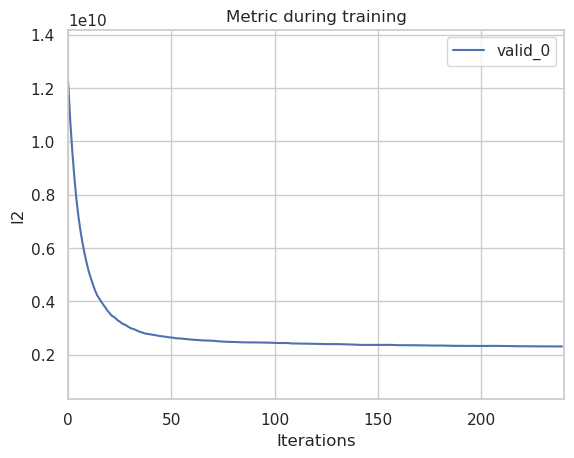

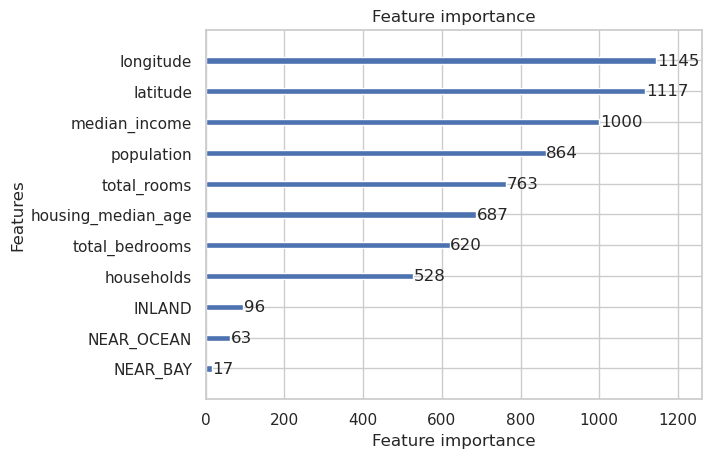

In [14]:
display(lgb.plot_metric(model))
display(lgb.plot_importance(model))